# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.unilm import *

In [9]:
config = unilm_config(vocab)

In [10]:
# config['n_layers'] = 8
# config['dec_layers'] = 0
config['n_layers'] = 8
config['dec_layers'] = 8
config['mem_len'] = 512
config['rand_bptt'] = False
config['bptt'] = 512
config['bs'] = 8

In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 139),
 'bs': 8,
 'bptt': 512,
 'vocab_size': 274,
 'dec_layers': 8}

In [12]:
base_path = Path('../../data/midi/v15/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [14]:
ns_dl_tfms = [mask_tfm, next_sentence_tfm]
ns_config = config.copy()
ns_config['bs'] *= 2
ns_data = load_music_data(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                          y_offset=0, dl_tfms=ns_dl_tfms, **ns_config)

In [15]:
xb,yb = ns_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([16, 512]),
 torch.Size([16, 512]),
 torch.Size([16, 512]),
 torch.Size([16, 512])]

## S2S Dataloading

In [16]:
s2s_dl_tfms = [s2s_tfm]
s2s_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                           preloader_cls=S2SPreloader, dl_tfms=s2s_dl_tfms, y_offset=1,
                           shuffle_dl=True, **config)


In [17]:
s2s_data.train_dl.dl.dataset.on_epoch_begin()
s2s_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = s2s_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512])]

### Load NextWord dataset (Language Model)

In [18]:
nw_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, 
                              vocab=vocab, dl_tfms=[nw_tfm], y_offset=1, 
                              train_tfms=[to_single_stream], valid_tfms=[to_single_stream], **config)

In [19]:
nw_data.train_dl.dl.dataset.on_epoch_begin()
nw_data.train_dl.dl.dataset.on_epoch_end()

In [20]:
xb,yb = nw_data.one_batch(); [x.shape for x in xb+yb]

[torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512]),
 torch.Size([8, 512])]

In [21]:
# xb, yb

## Datasets

In [22]:
datasets = [nw_data, s2s_data, ns_data]
# datasets = [s2s_data]

In [23]:
ns_data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fd7075acc18>, device=device(type='cuda'), tfms=[<function mask_tfm at 0x7fd6f057cae8>, <function next_sentence_tfm at 0x7fd6f057ca60>], collate_fn=<function data_collate at 0x7fd6fde88268>)

## Load

In [24]:
def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# Need to monkey patch pred_batch activation function for 2d array
loss_func_name = camel2snake(BertLoss.__name__)
basic_train.loss_func_name2activ[loss_func_name] = predict_func

In [25]:
loss_func = BertLoss(loss_mult=(1,1,1,1))
# learn = bert_model_learner(datasets[0], config.copy(), 
#                            loss_func=loss_func)

model = get_bert_model(config['vocab_size'], config=config.copy())
learn = MusicLearner(datasets[0], model, config=config, split_func=None, loss_func=loss_func)

False


In [26]:
learn.metrics = [mask_acc, ns_acc, s2s_acc, nw_acc]

In [27]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(BertTrainer(learn, datasets))

In [28]:
[type(c) for c in learn.callbacks]

[src.unilm.BertTrainer]

In [29]:
learn = learn.to_fp16()

### Training

In [30]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [31]:
# learn.validate()

In [32]:
learn.fit_one_cycle(12, 1e-4)

epoch,train_loss,valid_loss,mask_acc,ns_acc,s2s_acc,nw_acc,time
0,5.358785,5.403915,0.292386,0.000000,0.000000,0.364284,08:02
1,2.326481,2.207503,0.716928,0.000000,0.620887,0.000000,08:00
2,2.353969,2.060165,0.682571,0.545846,0.000000,0.000000,02:39
3,2.141457,2.094735,0.678572,0.000000,0.000000,0.691097,08:01
4,1.697149,1.734465,0.811282,0.000000,0.629615,0.000000,08:03
5,1.900262,1.803638,0.730322,0.593558,0.000000,0.000000,02:40
6,1.933269,1.899872,0.699826,0.000000,0.000000,0.712255,07:59
7,1.626789,1.585320,0.844339,0.000000,0.642031,0.000000,07:51
8,1.778966,1.684955,0.766357,0.533273,0.000000,0.000000,02:37
9,1.870629,1.792394,0.718160,0.000000,0.000000,0.721775,07:53


Updating mem length to: 512
Updating mem length to: 0
Updating mem length to: 512
Updating mem length to: 0
Updating mem length to: 512
Updating mem length to: 0
Updating mem length to: 512
Updating mem length to: 0
Updating mem length to: 512


In [33]:
learn.save('save_s2s_1')

## Load sample train

In [ ]:
# load_path = base_path/'piano_duet/models/save_s2s_1.pth'
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

In [ ]:
# learn.load('sample_train')

## Load existing

In [ ]:
saved_models = get_files(base_path/'models/unilm', recurse=True, extensions=['.pth']); saved_models

In [ ]:
# load_path = saved_models[1]
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

## Prediction

Prediction algo

In [61]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,7,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,song_url,section,numpy,ht_mode,midi,title,ht_time_signature,mxl,ht_offset,ht_bpm,ht_key,md5,midi_title,artist,genres,parts,source
193179,https://www.hooktheory.com/theorytab/view/ritc...,chorus,piano_duet/hooktheory/pianoroll/r/ritchie-vale...,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,la-bamba,4.0,NaN,0.0,144.0,C,aeee134e4034e5f98bb630c56d2f7f8c,La Bamba,ritchie-valen,"Pop,Rock",chorus,hooktheory_c


In [62]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [63]:
seed_len = 40
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

In [64]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [65]:
xb

tensor([[  0,   1,   8, 150,  64, 141,   8, 141,  66, 141,   8, 141,  68, 141,
           8, 141,  69, 143,  64, 147,  61, 147,  57, 147,   8, 143,  73, 141,
           8, 141,  76, 141,   8, 141,  74, 141,  69, 147,  66, 147,  62, 147,
           8, 141,  74, 141,   8, 141,  78, 141,   8, 141,  76, 143,   8, 141,
          59, 147,  56, 147,  52, 147,   8, 141,  64, 141,   8, 141,  68, 141,
           8, 141,  71, 141,   8, 141,  74, 141,  69, 147,  66, 147]],
       device='cuda:0')

In [66]:
# task_type = torch.full_like(xb, TaskType.NextWord.value)

# learn.model.reset()

# res = learn.pred_batch(batch=((xb,task_type,xb),xb)); res

# preds = loss_batch(learn.model.eval(), (xb,task_type,xb), yb); preds

In [70]:
# last = res[-1][0, -1]; last[143]
# idx = torch.multinomial(res[-1][0, -1], 1).item(); idx

In [71]:

def predict_nw(self, xb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
    seed = xb.cpu().numpy().squeeze()
    yb = torch.ones_like(xb)
    new_idx = []
#     self.mask = False
    self.model.reset()

    for i in progress_bar(range(n_words), leave=True):
#         print(xb)
        task_type = torch.full_like(xb, TaskType.NextWord.value)
        
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        res = self.pred_batch(batch=((xb,task_type,xb),xb))[-1][0, -1] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
        new_idx.append(idx)
#         t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
#         xb = torch.cat((xb, t_idx), dim=-1)
        xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return np.array(new_idx), seed


In [72]:
# vocab.itos[143]

In [73]:
if xb.shape[0] > 1: xb = xb[0][None]
seed = xb.cpu().numpy().squeeze()
yb = torch.ones_like(xb)
res = learn.pred_batch(batch=((xb, torch.full_like(xb, TaskType.NextWord.value),xb),(yb)))
res[-1][0, -1][141]

tensor(0.0004)

In [ ]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

In [ ]:
[vocab.itos[i] for i in out_s]

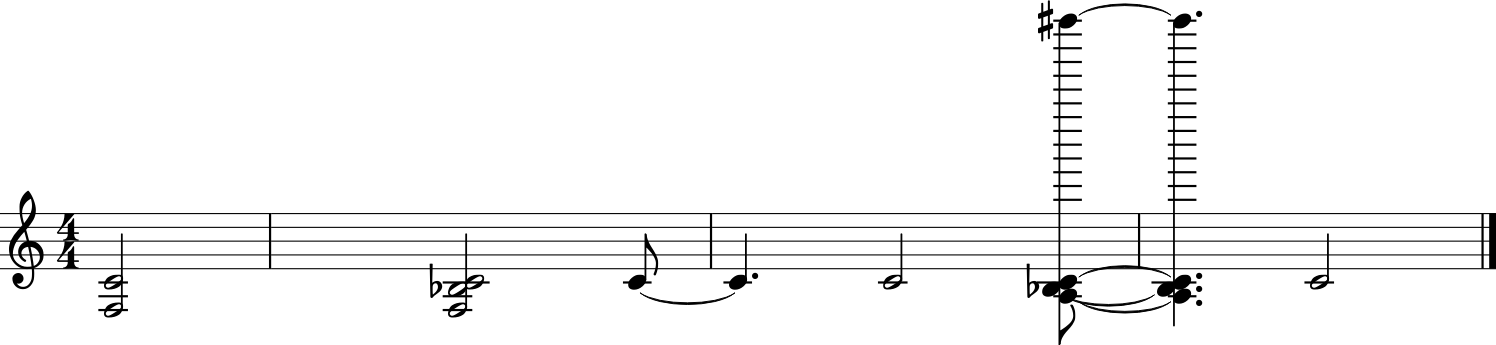

In [76]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

## Predict Seq2Seq

In [34]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,7,8,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_offset,ht_bpm,ht_mode,midi,ht_time_signature,parts,title,section,song_url,md5,ht_key,midi_title,genres,source,artist,mxl,numpy
192022,0.0,144.0,1.0,midi_sources/hooktheory/pianoroll/r/ritchie-va...,4.0,chorus,la-bamba,chorus,https://www.hooktheory.com/theorytab/view/ritc...,aeee134e4034e5f98bb630c56d2f7f8c,C,La Bamba,"Pop,Rock",hooktheory_c,ritchie-valen,NaN,s2s_encode/hooktheory/pianoroll/r/ritchie-vale...


In [35]:
idx = 0
file = base_path/results.numpy.values[idx];
orig = base_path/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v15/s2s_encode/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [37]:
melody_np, chord_np = np.load(file, allow_pickle=True)

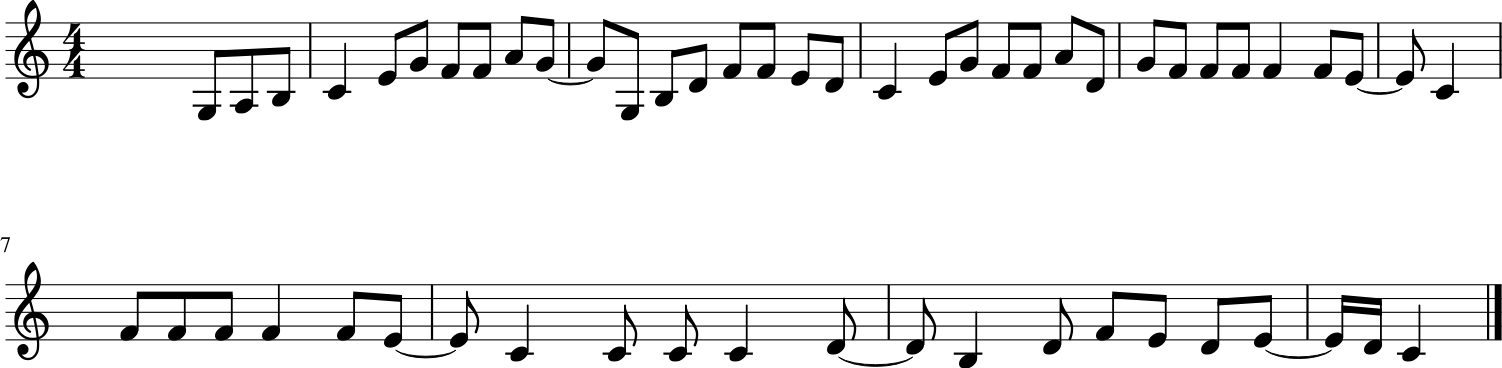

In [39]:
npenc2stream(melody_np).show()

In [ ]:

class S2SPreloader(Callback):
    def __init__(self, dataset:LabelList, bptt:int=512, y_offset=1, **kwargs):
        # y_offset = extra padding for translation
        self.dataset,self.bptt = dataset,bptt
        self.vocab = vocab
        self.y_offset = y_offset
        self.single_tfm = partial(to_single_stream, vocab=vocab)
        self.transpose_tfm = partial(rand_transpose_tfm, note_range=vocab.note_range, rand_range=(0,12))
    
    def __getitem__(self, k:int):
        item,_ = self.dataset[k]
        x,y = item
        
        melody_meta = np.array([self.vocab.stoi[MSEQ], self.vocab.stoi[avg_tempo(x)]]) # pad should be average notes - tempo
        chord_meta = np.array([self.vocab.stoi[CSEQ], self.vocab.stoi[avg_tempo(y)]])
        x = self.single_tfm(x, start_seq=melody_meta)
        y = self.single_tfm(y, start_seq=chord_meta)
        
        x,y = self.transpose_tfm((x,y))
        if random.randint(0,1) == 1: x,y = y,x # switch translation order around
        
        x = np.pad(x, (0,max(0,self.bptt-len(x))), 'constant', constant_values=vocab.pad_idx)[:self.bptt]
        y = np.pad(y, (self.y_offset,max(0,self.bptt-len(y))), 'constant', constant_values=(vocab.stoi[CLS], vocab.pad_idx))[:self.bptt+self.y_offset]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [79]:
def partenc2seq2seq(part_np, part_type=MSEQ, vocab=vocab, bptt=512, translate=False):
    part_meta = np.array([vocab.stoi[part_type], vocab.stoi[avg_tempo(chord_np)]])
    yb = to_single_stream(chord_np, start_seq=part_meta)
    if translate:
        yb = np.pad(yb, (1,bptt), 'constant', constant_values=(vocab.stoi[CLS], vocab.pad_idx))[:bptt]
    else:
        yb = np.pad(yb, (0,bptt), 'constant', constant_values=vocab.pad_idx)[:bptt]
    return yb

In [80]:
mpart = partenc2seq2seq(melody_np)

In [81]:
cpart = partenc2seq2seq(chord_np, translate=True)

In [87]:
xb = mpart; xb

array([  6, 273,   8, 156, ...,   1,   1,   1,   1])

In [88]:
yb = cpart; yb

array([  3,   6, 273,   8, ...,   1,   1,   1,   1])

In [89]:
xb.shape, yb.shape

((512,), (512,))

In [90]:
xb = torch.tensor(xb)[None].cuda()
yb = torch.tensor(yb)[None].cuda()

In [ ]:
learn.model.update_mem_len()

In [121]:

def predict_s2s(self, xb:Tensor, yb:Tensor, n_words:int=128):
    if xb.shape[0] > 1: xb = xb[0][None]
#     seed = xb.cpu().numpy().squeeze()
    yb_seed = yb[:, :3]
#     new_idx = []
#     self.mask = False
    self.model.reset()
    self.model.update_mem_len(TaskType.Seq2Seq.value)

    for i in progress_bar(range(n_words), leave=True):
#         print(xb)
        task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
        pad = xb.shape[-1]-yb_seed.shape[-1]
        yb_inp = F.pad(yb_seed, (0,pad), value=vocab.pad_idx)
        # Masking last - bert
#         mask_last = torch.cat((xb, torch.tensor(vocab.mask_idx, device=xb.device).view(1, 1)), dim=-1)
#         res = self.pred_batch(batch=((mask_last,task_type,mask_last),(yb)))[0][0, -1] # task1, task2 - (bs x ts x vocab)
        
        # Next Word
        idx = yb_seed.shape[-1]
        res = self.pred_batch(batch=((xb,task_type,yb_inp),yb_inp))[-1][0, idx] # task1, task2 - (bs x ts x vocab)

        # Encoder only - nw
#         res = self.pred_batch(batch=((xb,task_type,xb),xb))[0][0, -1] # task1, task2 - (bs x ts x vocab)

        # Use first temperatures value if last prediction was duration
        res.pow_(1 / (0.5))

        idx = torch.multinomial(res, 1).item()
    
#         new_idx.append(idx)
        t_idx = torch.tensor(idx, device=xb.device).view(1, 1)
        yb_seed = torch.cat((yb_seed, t_idx), dim=-1)
#         xb = xb.new_tensor([idx])[None]
        
#     self.mask = True
    return yb_seed


In [141]:
task_type = torch.full_like(xb, TaskType.Seq2Seq.value)
res = learn.pred_batch(batch=((xb,task_type,yb),yb))

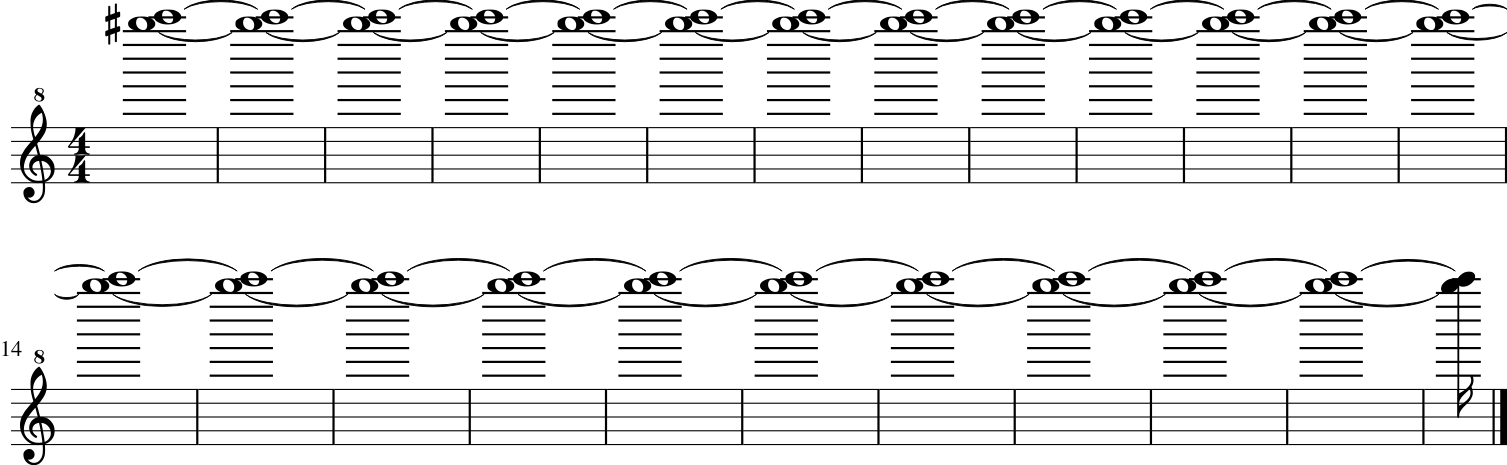

In [142]:
z = res[-1].argmax(1)
z_str = to_double_stream(z.cpu().numpy()[:,:])
npenc2stream(z_str).show()

In [143]:
res[0].argmax(1)

tensor([[  0, 145,   1,   0, 149,   0,   0,   1,  26, 145, 454,   1, 454,   1,
           0,   1,   1,   1,   1, 454,   1, 145, 454, 145,   1,   1,   1, 145,
         145,   1,   1,   1,   1, 145, 145, 145,   0,   1, 454, 454,   1, 503,
         503, 454, 503, 510, 510, 146, 146, 146,   1, 140, 120, 138, 138,   1,
          54,   8, 144, 116, 144,  38,  48, 142, 132, 142,  46,   1, 140,  12,
         511, 140,   1, 140, 511, 511, 140, 357, 511,   1, 511, 140, 147, 148,
           1, 357,   0, 511, 148, 357, 511,   1, 511, 140, 357, 511,   1, 511,
         503, 510, 503, 503, 510, 503, 504, 503, 510, 510, 503, 455, 503, 454,
         454, 454, 145, 454,   1,   1, 454, 145,   1,   0,   1,   1, 454,   1,
         145, 145,   1,   1,   1,   1, 454,   1, 145,   1, 454,   1, 145,   1,
           3, 141,   3, 141,   0, 141,   3, 119, 141, 141,   0,   1, 141, 141,
           3, 141,   3, 141, 141,   1,   0, 141,   0,   0, 141, 141, 141, 141,
           0, 141,   0, 141,   1, 141,   1,   1,   0

In [122]:
yb_seed = yb[:,:3]
pad = xb.shape[-1]-yb_seed.shape[-1]

In [123]:
xb.shape

torch.Size([1, 512])

In [124]:
yb.shape

torch.Size([1, 512])

In [125]:
yb_inp = F.pad(yb_seed, (0,pad), value=vocab.pad_idx)

In [126]:
yb_inp.shape

torch.Size([1, 512])

In [127]:
yb_out = predict_s2s(learn, xb, yb)

In [130]:
yb_out

tensor([[  3,   6, 273,   8, 141,   8,   8,   8, 141,   8,   8,   8,   8,   8,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,
           8,   8,   8,   8, 141,   8,   8,   8,   8,   8, 141, 141, 145, 141,
           8,   8, 141, 141, 141,   8, 141,   8,   8,   8, 141,   8,   8,  61,
           8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8, 141,   8, 141,
           8, 141,   8,   8,   8,   8, 141, 141,   8, 141,   8,   8,   8, 141,
         141, 141,   8,   8,   8,   8,   8, 141,   8,   8,   8, 141,   8,   8,
           8,   8,   8, 141, 141,   8,   8,   8, 141,   8,   8, 140,   8,   8,
           8,   8,   8, 141,   8,   8,   8,   8,   8,   8, 141,   8,   8,   8,
         141,   8,   8, 141,   8]], device='cuda:0')

In [128]:
yb_test = to_double_stream(yb_out.cpu().numpy()[:,1:])

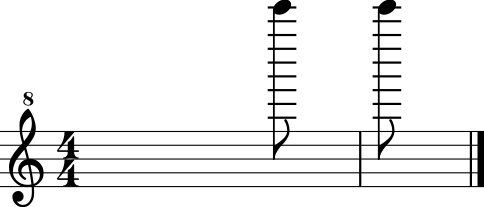

In [129]:
npenc2stream(yb_test).show()